In [169]:
#importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_columns', None)

In [170]:
data1 = pd.read_csv('C:/Data_Science/Personal_Notebooks/Podcast_listening_time_prediction/train.csv')
data2 = pd.read_csv('C:/Data_Science/Personal_Notebooks/Podcast_listening_time_prediction/test.csv')

train = data1.copy()
test = data2.copy()

submission_df = data2.copy()
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [171]:
train = train.fillna(train.median(numeric_only= True))
test = test.fillna(test.median(numeric_only= True))

In [172]:
from my_functions import lower_case

lower_case(train, ['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
        'Genre', 'Host_Popularity_percentage', 'Publication_Day',
        'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
        'Episode_Sentiment', 'Listening_Time_minutes'])

lower_case(test, ['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
        'Genre', 'Host_Popularity_percentage', 'Publication_Day',
        'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
        'Episode_Sentiment'])

In [173]:
days_encoding = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

train['weekday_encoded'] = train['publication_day'].map(days_encoding)

test['weekday_encoded'] = test['publication_day'].map(days_encoding)

publication_encoding = {
    'Morning': 0,
    'Afternoon': 1,
    'Evening': 2,
    'Night': 4
}

train['publication_encoded'] = train['publication_time'].map(publication_encoding)

test['publication_encoded'] = test['publication_time'].map(publication_encoding)

train = train.drop(columns=['publication_day', 'publication_time'])

test = test.drop(columns=['publication_day', 'publication_time'])

print("Train df after encoding of day and time: \n", train.head(3))
print("Test df after encoding of day and time: \n", test.head(3))

Train df after encoding of day and time: 
    id     podcast_name episode_title  episode_length_minutes       genre  \
0   0  Mystery Matters    Episode 98                   63.84  True Crime   
1   1    Joke Junction    Episode 26                  119.80      Comedy   
2   2   Study Sessions    Episode 16                   73.90   Education   

   host_popularity_percentage  guest_popularity_percentage  number_of_ads  \
0                       74.81                        53.58            0.0   
1                       66.95                        75.95            2.0   
2                       69.97                         8.97            0.0   

  episode_sentiment  listening_time_minutes  weekday_encoded  \
0          Positive                31.41998                4   
1          Negative                88.01241                6   
2          Negative                44.92531                2   

   publication_encoded  
0                    4  
1                    1  
2          

In [174]:
episode_mapping = {
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1
}

train['episode_sentiment_encoded'] = train['episode_sentiment'].map(episode_mapping)
test['episode_sentiment_encoded'] = test['episode_sentiment'].map(episode_mapping)

train = train.drop(columns='episode_sentiment')
test = test.drop(columns='episode_sentiment')

print("Train df after encoding the sentiment: \n", train.head(3))
print("Test df after encoding the sentiment: \n", test.head(3))

Train df after encoding the sentiment: 
    id     podcast_name episode_title  episode_length_minutes       genre  \
0   0  Mystery Matters    Episode 98                   63.84  True Crime   
1   1    Joke Junction    Episode 26                  119.80      Comedy   
2   2   Study Sessions    Episode 16                   73.90   Education   

   host_popularity_percentage  guest_popularity_percentage  number_of_ads  \
0                       74.81                        53.58            0.0   
1                       66.95                        75.95            2.0   
2                       69.97                         8.97            0.0   

   listening_time_minutes  weekday_encoded  publication_encoded  \
0                31.41998                4                    4   
1                88.01241                6                    1   
2                44.92531                2                    2   

   episode_sentiment_encoded  
0                          1  
1             

In [175]:
train = train.drop(columns=['id','podcast_name', 'episode_title', 'genre'])
test = test.drop(columns=['id','podcast_name', 'episode_title', 'genre'])

In [176]:
target_placeholder = train.pop('listening_time_minutes')

train['listening_time_minutes'] = target_placeholder

train

,episode_length_minutes,host_popularity_percentage,guest_popularity_percentage,number_of_ads,weekday_encoded,publication_encoded,episode_sentiment_encoded,listening_time_minutes
0,63.84,74.81,53.58,0.0,4,4,1,31.41998
1,119.80,66.95,75.95,2.0,6,1,-1,88.01241
2,73.90,69.97,8.97,0.0,2,2,-1,44.92531
3,67.17,57.22,78.70,2.0,1,0,1,46.27824
4,110.51,80.07,58.68,3.0,1,1,0,75.61031
...,...,...,...,...,...,...,...,...
749995,75.66,69.36,53.58,0.0,6,0,-1,56.87058
749996,75.75,35.21,53.58,2.0,6,4,0,45.46242
749997,30.98,78.58,84.89,0.0,4,0,-1,15.26000
749998,108.98,45.39,93.27,0.0,4,0,-1,100.72939


In [177]:
train['combined_popularity'] = (train['host_popularity_percentage'] / 100.0) * (train['guest_popularity_percentage'] / 100.0) *100.0
test['combined_popularity'] = (test['host_popularity_percentage'] / 100.0) * (test['guest_popularity_percentage'] / 100.0) *100.0

train['popularity_difference'] = (train['host_popularity_percentage'] - train['guest_popularity_percentage'])
test['popularity_difference'] = (test['host_popularity_percentage'] - test['guest_popularity_percentage'])

print("Train df after creation of 2 new features: \n", train.head(3))
print("Test df after creation of 2 new features: \n", test.head(3))

Train df after creation of 2 new features: 
    episode_length_minutes  host_popularity_percentage  \
0                   63.84                       74.81   
1                  119.80                       66.95   
2                   73.90                       69.97   

   guest_popularity_percentage  number_of_ads  weekday_encoded  \
0                        53.58            0.0                4   
1                        75.95            2.0                6   
2                         8.97            0.0                2   

   publication_encoded  episode_sentiment_encoded  listening_time_minutes  \
0                    4                          1                31.41998   
1                    1                         -1                88.01241   
2                    2                         -1                44.92531   

   combined_popularity  popularity_difference  
0            40.083198                  21.23  
1            50.848525                  -9.00  
2       

In [178]:
weekend_days = [6, 7]

train['is_weekend'] = train['weekday_encoded'].apply(lambda x: 1 if x in weekend_days else 0)
test['is_weekend'] = test['weekday_encoded'].apply(lambda x: 1 if x in weekend_days else 0)

In [179]:
target_placeholder = train.pop('listening_time_minutes')

train['listening_time_minutes'] = target_placeholder

train

,episode_length_minutes,host_popularity_percentage,guest_popularity_percentage,number_of_ads,weekday_encoded,publication_encoded,episode_sentiment_encoded,combined_popularity,popularity_difference,is_weekend,listening_time_minutes
0,63.84,74.81,53.58,0.0,4,4,1,40.083198,21.23,0,31.41998
1,119.80,66.95,75.95,2.0,6,1,-1,50.848525,-9.00,1,88.01241
2,73.90,69.97,8.97,0.0,2,2,-1,6.276309,61.00,0,44.92531
3,67.17,57.22,78.70,2.0,1,0,1,45.032140,-21.48,0,46.27824
4,110.51,80.07,58.68,3.0,1,1,0,46.985076,21.39,0,75.61031
...,...,...,...,...,...,...,...,...,...,...,...
749995,75.66,69.36,53.58,0.0,6,0,-1,37.163088,15.78,1,56.87058
749996,75.75,35.21,53.58,2.0,6,4,0,18.865518,-18.37,1,45.46242
749997,30.98,78.58,84.89,0.0,4,0,-1,66.706562,-6.31,0,15.26000
749998,108.98,45.39,93.27,0.0,4,0,-1,42.335253,-47.88,0,100.72939


In [180]:
train = train.drop(columns=['host_popularity_percentage', 'guest_popularity_percentage', 'weekday_encoded'])
test = test.drop(columns=['host_popularity_percentage', 'guest_popularity_percentage', 'weekday_encoded'])

train

,episode_length_minutes,number_of_ads,publication_encoded,episode_sentiment_encoded,combined_popularity,popularity_difference,is_weekend,listening_time_minutes
0,63.84,0.0,4,1,40.083198,21.23,0,31.41998
1,119.80,2.0,1,-1,50.848525,-9.00,1,88.01241
2,73.90,0.0,2,-1,6.276309,61.00,0,44.92531
3,67.17,2.0,0,1,45.032140,-21.48,0,46.27824
4,110.51,3.0,1,0,46.985076,21.39,0,75.61031
...,...,...,...,...,...,...,...,...
749995,75.66,0.0,0,-1,37.163088,15.78,1,56.87058
749996,75.75,2.0,4,0,18.865518,-18.37,1,45.46242
749997,30.98,0.0,0,-1,66.706562,-6.31,0,15.26000
749998,108.98,0.0,0,-1,42.335253,-47.88,0,100.72939


In [181]:
train['popularity_difference'] = abs(train['popularity_difference'])
test['popularity_difference'] = abs(test['popularity_difference'])

train['ad_density'] = train['number_of_ads'] / (train['episode_length_minutes'] + 0.1)
test['ad_density'] = test['number_of_ads'] / (train['episode_length_minutes'] + 0.1)




In [182]:
train

,episode_length_minutes,number_of_ads,publication_encoded,episode_sentiment_encoded,combined_popularity,popularity_difference,is_weekend,listening_time_minutes,ad_density
0,63.84,0.0,4,1,40.083198,21.23,0,31.41998,0.000000
1,119.80,2.0,1,-1,50.848525,9.00,1,88.01241,0.016681
2,73.90,0.0,2,-1,6.276309,61.00,0,44.92531,0.000000
3,67.17,2.0,0,1,45.032140,21.48,0,46.27824,0.029731
4,110.51,3.0,1,0,46.985076,21.39,0,75.61031,0.027122
...,...,...,...,...,...,...,...,...,...
749995,75.66,0.0,0,-1,37.163088,15.78,1,56.87058,0.000000
749996,75.75,2.0,4,0,18.865518,18.37,1,45.46242,0.026368
749997,30.98,0.0,0,-1,66.706562,6.31,0,15.26000,0.000000
749998,108.98,0.0,0,-1,42.335253,47.88,0,100.72939,0.000000


In [183]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

import catboost as cb
from catboost import CatBoostRegressor


In [184]:
#testing different non linear models

def train_and_eval_models(X_train, X_test, y_train, y_test):

    #models to test
    models = {
        "LightGBM" : LGBMRegressor(),
        "catboost" : CatBoostRegressor()
    }

    print("Starting the training process.")

    #list to store results

    results = []

    #scaling data just for LogisticRegression

    for name, model in models.items():
        print(f"Training model: {name}")

        model.fit(X_train, y_train)

        y_train_predict = model.predict(X_train)
        y_test_predict = model.predict(X_test)

        results.append({
            "Model": name,
            "Train MAE": mean_absolute_error(y_train, y_train_predict),
            "Test MAE": mean_absolute_error(y_test, y_test_predict),
            "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_predict)),
            "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_predict)),
            "Train R2": r2_score(y_train, y_train_predict),
            "Test R2": r2_score(y_test, y_test_predict)
        })

    # Converting results into a DataFrame
    results_df = pd.DataFrame(results)

    print("\nModel Performance Summary:")
    print(results_df)

    return results_df, model

In [185]:
target_placeholder = train.pop('listening_time_minutes')

train['listening_time_minutes'] = target_placeholder

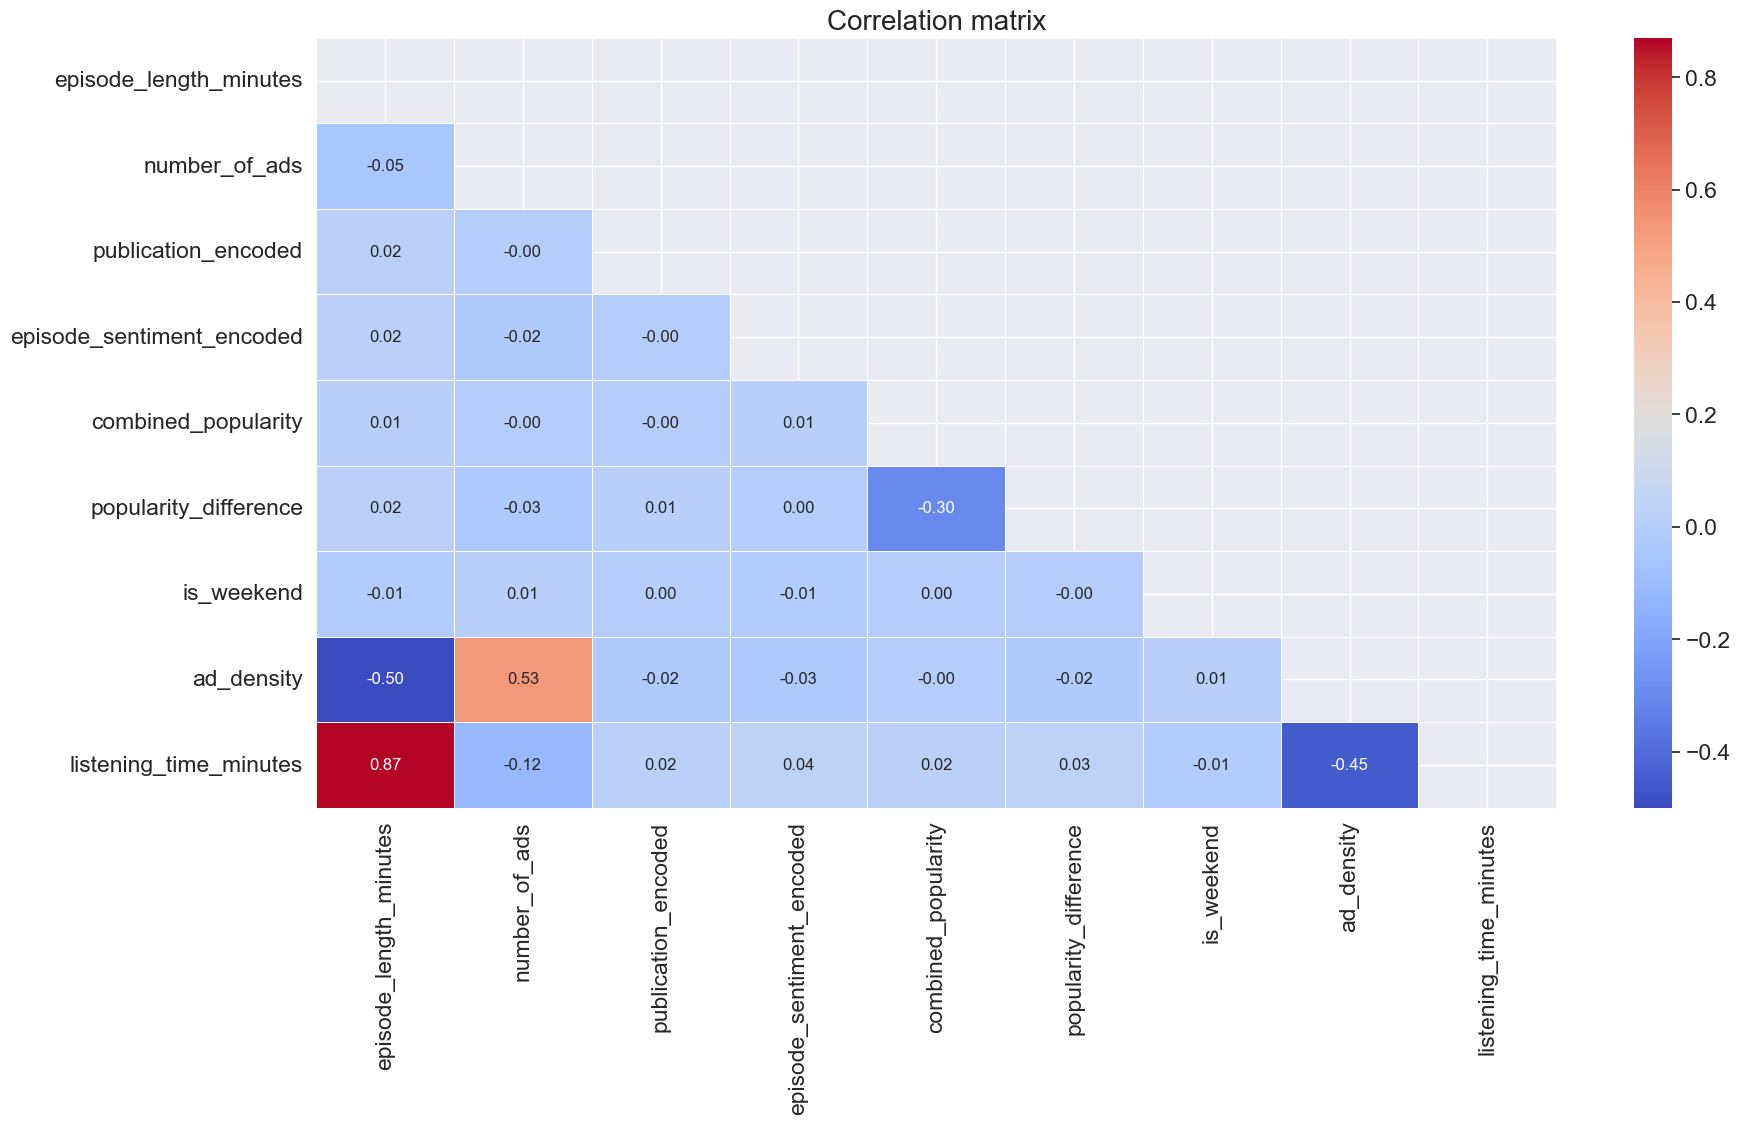

In [186]:
num_corr = round(train.corr(), 2)

# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

f, ax = plt.subplots(figsize=(20, 10))
sns.set_theme(font_scale=1.5) # increase font size

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="coolwarm", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Correlation matrix", fontsize=20) # add title
plt.show()

In [187]:
train = train.drop(columns=['number_of_ads', 'combined_popularity'])
test = test.drop(columns=['number_of_ads', 'combined_popularity'])

In [188]:
from sklearn.model_selection import train_test_split

X = train.drop(columns='listening_time_minutes') #target
y = train['listening_time_minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [189]:
results_df = train_and_eval_models(X_train, X_test, y_train, y_test)

print(results_df)

Starting the training process.
Training model: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 774
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 6
[LightGBM] [Info] Start training from score 45.447808
Training model: catboost
Learning rate set to 0.112494
0:	learn: 24.9594697	total: 46.9ms	remaining: 46.8s
1:	learn: 23.0608768	total: 97.2ms	remaining: 48.5s
2:	learn: 21.4369216	total: 146ms	remaining: 48.5s
3:	learn: 20.0588368	total: 192ms	remaining: 47.7s
4:	learn: 18.8926812	total: 239ms	remaining: 47.6s
5:	learn: 17.9097362	total: 284ms	remaining: 47.1s
6:	learn: 17.0782691	total: 329ms	remaining: 46.7s
7:	learn: 16.3893378	total: 375ms	remaining: 46.5s
8:	learn: 15.8170566	total: 423ms	remaining: 46.6s
9:	learn: 15.3491171	t

In [190]:
train.columns

Index(['episode_length_minutes', 'publication_encoded',
       'episode_sentiment_encoded', 'popularity_difference', 'is_weekend',
       'ad_density', 'listening_time_minutes'],
      dtype='object')

In [191]:
train['episode_length_minutes'].describe()

count    750000.000000
mean         64.427546
std          30.996996
min           0.000000
25%          39.420000
50%          63.840000
75%          90.310000
max         325.240000
Name: episode_length_minutes, dtype: float64

In [192]:
train['listening_time_minutes'].describe()

count    750000.000000
mean         45.437406
std          27.138306
min           0.000000
25%          23.178350
50%          43.379460
75%          64.811580
max         119.970000
Name: listening_time_minutes, dtype: float64

In [193]:
train['KPI_met'] = train.apply(
    lambda row: 1 if (row['listening_time_minutes'] / row['episode_length_minutes'] * 100) > 85.0 else 0,
    axis=1
)

train

,episode_length_minutes,publication_encoded,episode_sentiment_encoded,popularity_difference,is_weekend,ad_density,listening_time_minutes,KPI_met
0,63.84,4,1,21.23,0,0.000000,31.41998,0
1,119.80,1,-1,9.00,1,0.016681,88.01241,0
2,73.90,2,-1,61.00,0,0.000000,44.92531,0
3,67.17,0,1,21.48,0,0.029731,46.27824,0
4,110.51,1,0,21.39,0,0.027122,75.61031,0
...,...,...,...,...,...,...,...,...
749995,75.66,0,-1,15.78,1,0.000000,56.87058,0
749996,75.75,4,0,18.37,1,0.026368,45.46242,0
749997,30.98,0,-1,6.31,0,0.000000,15.26000,0
749998,108.98,0,-1,47.88,0,0.000000,100.72939,1


In [194]:
train['KPI_met'].value_counts()

KPI_met
0    589004
1    160996
Name: count, dtype: int64

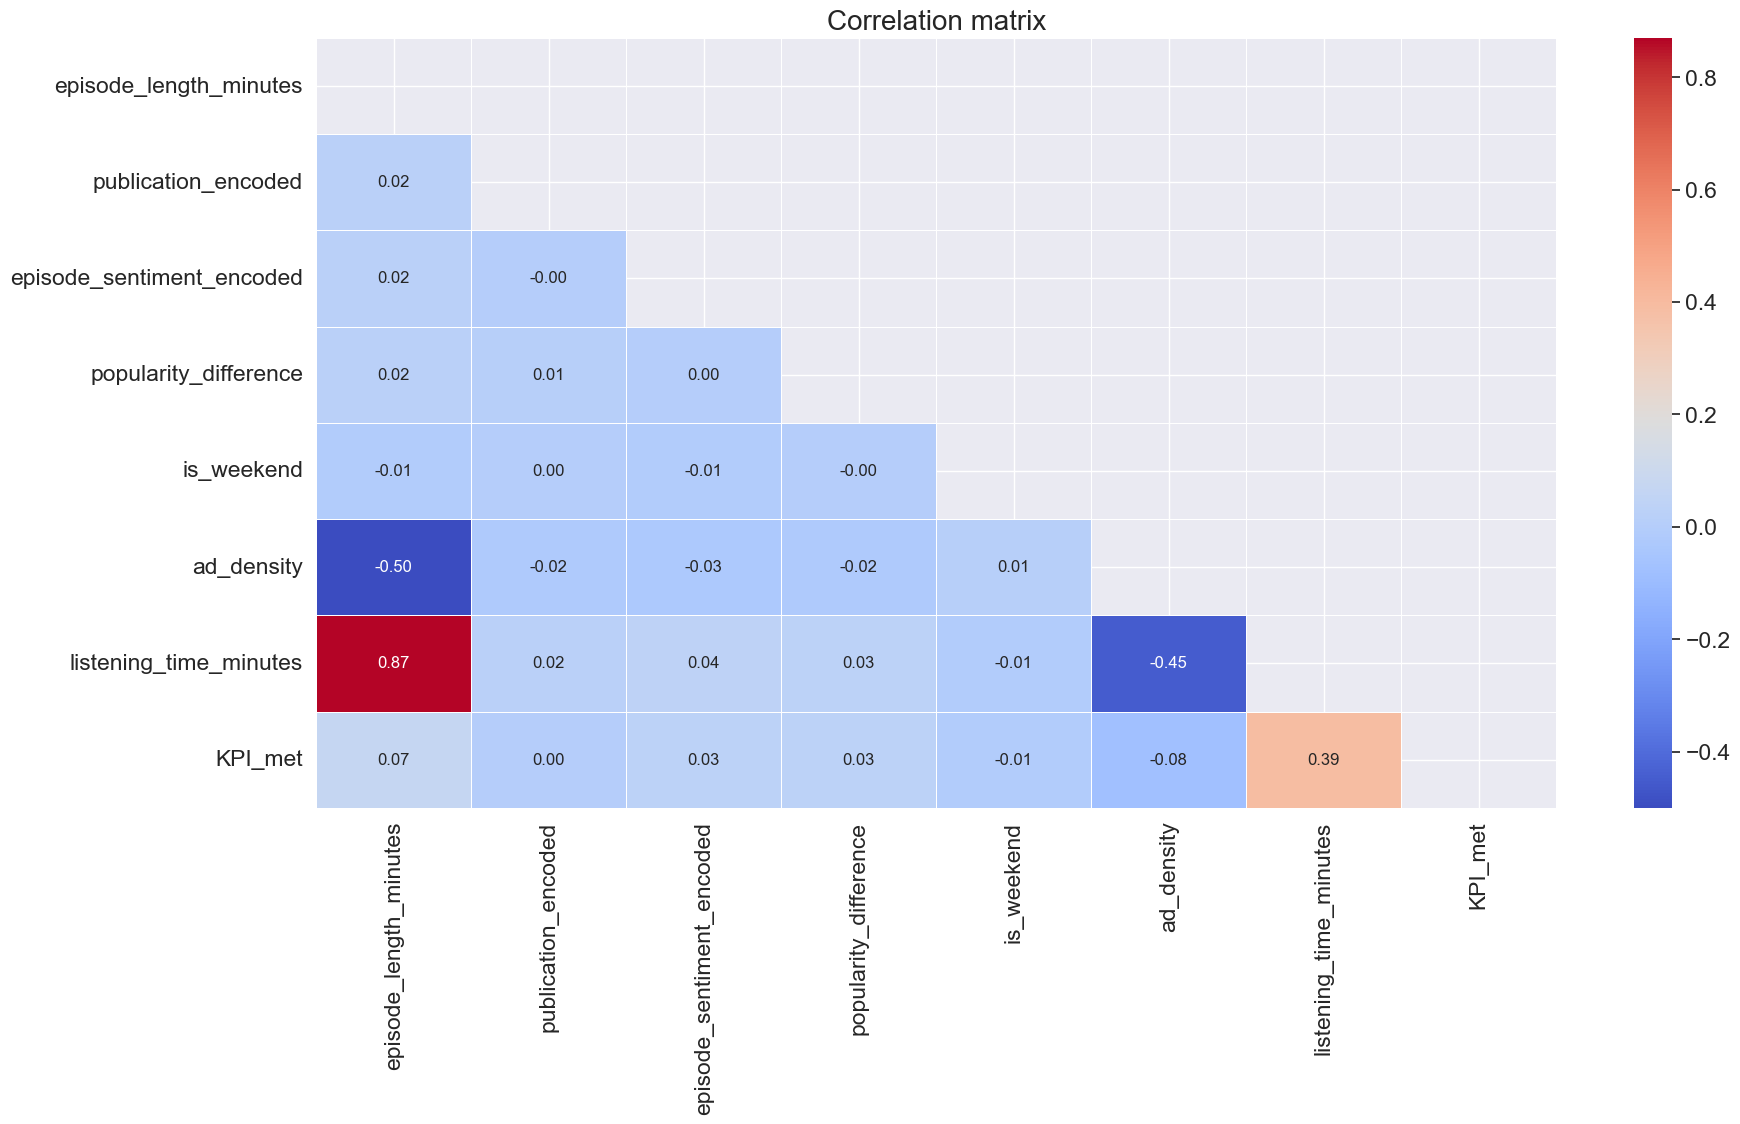

In [195]:
num_corr = round(train.corr(), 2)

# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

f, ax = plt.subplots(figsize=(20, 10))
sns.set_theme(font_scale=1.5) # increase font size

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="coolwarm", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Correlation matrix", fontsize=20) # add title
plt.show()

In [196]:
train.columns

Index(['episode_length_minutes', 'publication_encoded',
       'episode_sentiment_encoded', 'popularity_difference', 'is_weekend',
       'ad_density', 'listening_time_minutes', 'KPI_met'],
      dtype='object')

In [197]:
reduced_features = train.copy()

reduced_features = reduced_features.drop(columns=['publication_encoded',
       'episode_sentiment_encoded', 'popularity_difference', 'is_weekend']
)

reduced_features

,episode_length_minutes,ad_density,listening_time_minutes,KPI_met
0,63.84,0.000000,31.41998,0
1,119.80,0.016681,88.01241,0
2,73.90,0.000000,44.92531,0
3,67.17,0.029731,46.27824,0
4,110.51,0.027122,75.61031,0
...,...,...,...,...
749995,75.66,0.000000,56.87058,0
749996,75.75,0.026368,45.46242,0
749997,30.98,0.000000,15.26000,0
749998,108.98,0.000000,100.72939,1


In [198]:
target_placeholder = reduced_features.pop('listening_time_minutes')

reduced_features['listening_time_minutes'] = target_placeholder

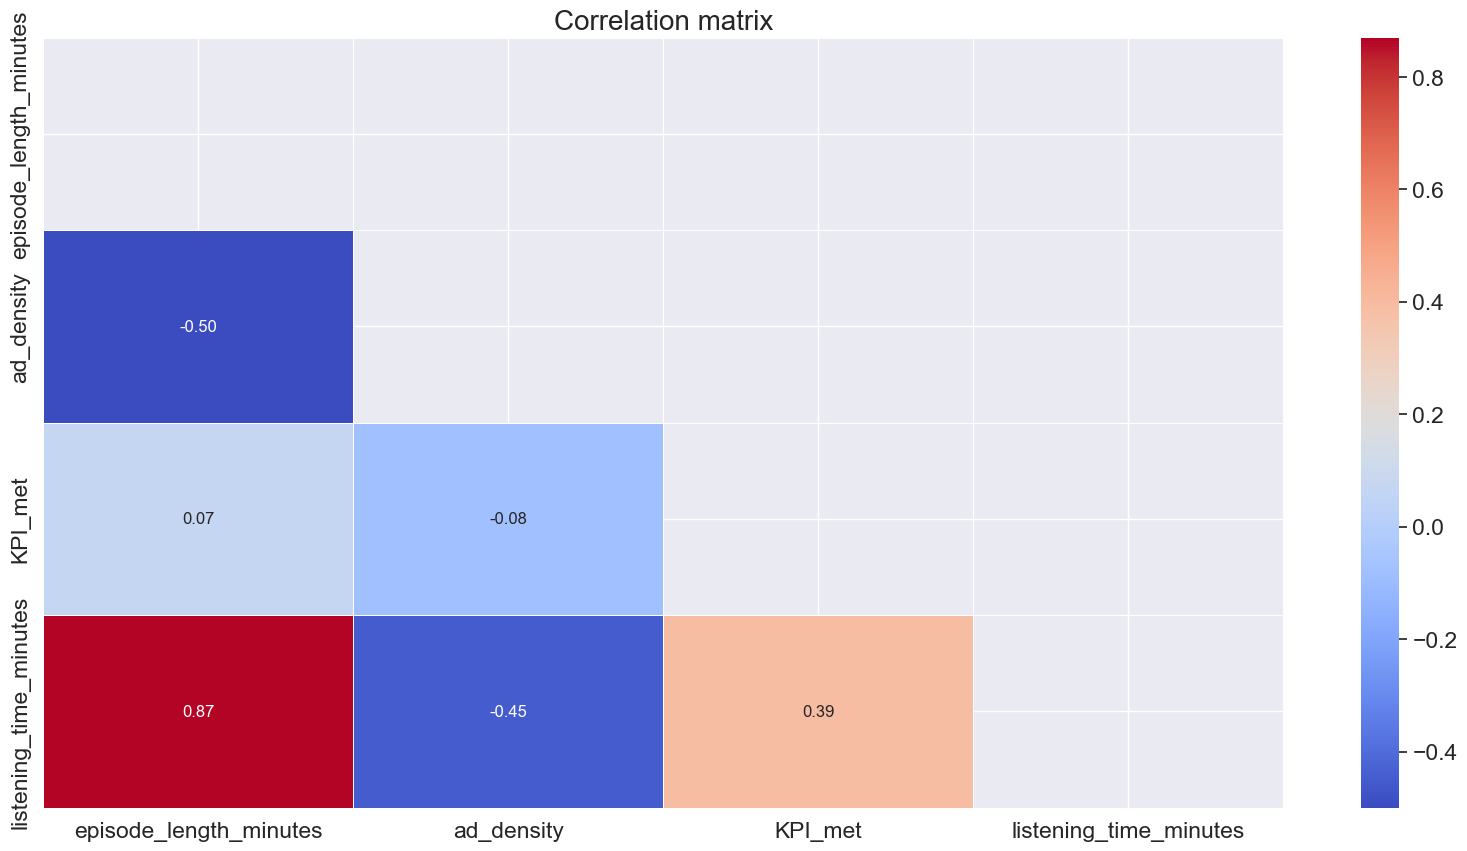

In [199]:
num_corr = round(reduced_features.corr(), 2)

# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

f, ax = plt.subplots(figsize=(20, 10))
sns.set_theme(font_scale=1.5) # increase font size

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="coolwarm", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Correlation matrix", fontsize=20) # add title
plt.show()

In [200]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [201]:
def train_and_eval_models(X_train, X_test, y_train, y_test):

    #models to test
    models = {
        "Linear Regression" : LinearRegression(),
        "Random Forest" : RandomForestRegressor(),
        "XGB" : XGBRegressor()
    }

    print("Starting the training process.")

    #list to store results

    results = []

    #scaling data just for LogisticRegression

    for name, model in models.items():
        print(f"Training model: {name}")

        model.fit(X_train, y_train)

        y_train_predict = model.predict(X_train)
        y_test_predict = model.predict(X_test)

        results.append({
            "Model": name,
            "Train MAE": mean_absolute_error(y_train, y_train_predict),
            "Test MAE": mean_absolute_error(y_test, y_test_predict),
            "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_predict)),
            "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_predict)),
            "Train R2": r2_score(y_train, y_train_predict),
            "Test R2": r2_score(y_test, y_test_predict)
        })

    # Converting results into a DataFrame
    results_df = pd.DataFrame(results)

    print("\nModel Performance Summary:")
    print(results_df)

    return results_df, model

In [202]:
results_df = train_and_eval_models(X_train, X_test, y_train, y_test)

print(results_df)

Starting the training process.
Training model: Linear Regression
Training model: Random Forest
Training model: XGB

Model Performance Summary:
               Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2  \
0  Linear Regression   9.942704  9.880497   13.544289  13.476588  0.750971   
1      Random Forest   3.695413  9.686646    5.542658  13.903767  0.958296   
2                XGB   9.554225  9.600822   13.120016  13.192550  0.766328   

    Test R2  
0  0.753178  
1  0.737282  
2  0.763473  
(               Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2  \
0  Linear Regression   9.942704  9.880497   13.544289  13.476588  0.750971   
1      Random Forest   3.695413  9.686646    5.542658  13.903767  0.958296   
2                XGB   9.554225  9.600822   13.120016  13.192550  0.766328   

    Test R2  
0  0.753178  
1  0.737282  
2  0.763473  , XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=Non

In [203]:
def train_and_eval_models(X_train, X_test, y_train, y_test):

    #models to test
    models = {
        "XGB" : XGBRegressor()
    }

    print("Starting the training process.")

    #list to store results

    results = []

    #scaling data just for LogisticRegression

    for name, model in models.items():
        print(f"Training model: {name}")

        model.fit(X_train, y_train)

        y_train_predict = model.predict(X_train)
        y_test_predict = model.predict(X_test)

        results.append({
            "Model": name,
            "Train MAE": mean_absolute_error(y_train, y_train_predict),
            "Test MAE": mean_absolute_error(y_test, y_test_predict),
            "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_predict)),
            "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_predict)),
            "Train R2": r2_score(y_train, y_train_predict),
            "Test R2": r2_score(y_test, y_test_predict)
        })

    # Converting results into a DataFrame
    results_df = pd.DataFrame(results)

    print("\nModel Performance Summary:")
    print(results_df)

    return results_df, model

In [204]:
import pickle

xgb_monday_result_df, final_model = train_and_eval_models(X_train, X_test, y_train, y_test)

print(xgb_monday_result_df)

# Saving the model to a file
with open('xgb_simplified_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)

print("Model saved successfully to 'xgb_simplified_model.pkl'")


Starting the training process.
Training model: XGB

Model Performance Summary:
  Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2   Test R2
0   XGB   9.554225  9.600822   13.120016   13.19255  0.766328  0.763473
  Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2   Test R2
0   XGB   9.554225  9.600822   13.120016   13.19255  0.766328  0.763473
Model saved successfully to 'xgb_simplified_model.pkl'


In [205]:
submission_df = submission_df.fillna(submission_df.median(numeric_only= True))

lower_case(submission_df, ['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
        'Genre', 'Host_Popularity_percentage', 'Publication_Day',
        'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
        'Episode_Sentiment']
        )

days_encoding = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

submission_df['weekday_encoded'] = submission_df['publication_day'].map(days_encoding)

publication_encoding = {
    'Morning': 0,
    'Afternoon': 1,
    'Evening': 2,
    'Night': 4
}


submission_df['publication_encoded'] = submission_df['publication_time'].map(publication_encoding)

submission_df = submission_df.drop(columns=['publication_day', 'publication_time'])

episode_mapping = {
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1
}

submission_df['episode_sentiment_encoded'] = submission_df['episode_sentiment'].map(episode_mapping)

submission_df = submission_df.drop(columns='episode_sentiment')

submission_df = submission_df.drop(columns=['podcast_name', 'episode_title', 'genre'])

submission_df['combined_popularity'] = (submission_df ['host_popularity_percentage'] / 100.0) * (submission_df ['guest_popularity_percentage'] / 100.0) *100.0

submission_df['popularity_difference'] = (submission_df ['host_popularity_percentage'] - submission_df ['guest_popularity_percentage'])

weekend_days = [6, 7]

submission_df['is_weekend'] = submission_df['weekday_encoded'].apply(lambda x: 1 if x in weekend_days else 0)

submission_df = submission_df.drop(columns=['host_popularity_percentage', 'guest_popularity_percentage', 'weekday_encoded'])

submission_df['popularity_difference'] = abs(submission_df['popularity_difference'])

submission_df['ad_density'] = submission_df['number_of_ads'] / (submission_df['episode_length_minutes'] + 0.1)

submission_df = submission_df.drop(columns=['number_of_ads', 'combined_popularity'])

submission_df

,id,episode_length_minutes,publication_encoded,episode_sentiment_encoded,popularity_difference,is_weekend,ad_density
0,750000,78.96,2,0,15.22,1,0.012649
1,750001,27.87,0,0,17.93,1,0.000000
2,750002,69.10,2,1,29.62,0,0.000000
3,750003,115.39,0,1,28.35,1,0.017318
4,750004,72.32,0,0,46.80,0,0.027617
...,...,...,...,...,...,...,...
249995,999995,21.05,2,-1,30.63,1,0.141844
249996,999996,85.50,4,-1,10.95,1,0.023364
249997,999997,12.11,2,0,47.77,0,0.081900
249998,999998,113.46,4,1,50.12,0,0.026418


In [206]:
submission_df.columns

Index(['id', 'episode_length_minutes', 'publication_encoded',
       'episode_sentiment_encoded', 'popularity_difference', 'is_weekend',
       'ad_density'],
      dtype='object')

In [207]:
submission_df = submission_df.drop(columns=['publication_encoded',
       'episode_sentiment_encoded', 'popularity_difference', 'is_weekend'])

In [208]:
#creating the submission file

with open('xgb_simplified_model.pkl', 'rb') as file:
    final_model = pickle.load(file)

X_submission_test = submission_df.drop(columns='id')

y_submission_pred = final_model.predict(X_submission_test)

sumbission = pd.DataFrame({
    'id': submission_df['id'],
    'Listening_Time_Minutes': y_submission_pred
})

sumbission.to_csv('submission2.csv', index= False)

print("Submission File created")

ValueError: feature_names mismatch: ['episode_length_minutes', 'publication_encoded', 'episode_sentiment_encoded', 'popularity_difference', 'is_weekend', 'ad_density'] ['episode_length_minutes', 'ad_density']
expected episode_sentiment_encoded, publication_encoded, is_weekend, popularity_difference in input data